In [0]:
import pandas as pd
import numpy as np
import datetime as dt
import tensorflow as tf
from tensorflow import feature_column as tfc
from six import iteritems

In [0]:
data = pd.read_excel("Online Retail.xlsx")
data
data.columns = [col.lower() for col in data.columns]
data = data[data['customerid'].notnull()]

In [0]:
data.head()

,invoiceno,stockcode,description,quantity,invoicedate,unitprice,customerid,country,date,priceqty
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,2010-12-01,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,2010-12-01,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,2010-12-01,20.34


In [0]:
data['invoicedate'] = pd.to_datetime(data['invoicedate'])
data['date'] = data['invoicedate'].dt.date
data['priceqty'] = data['unitprice']*data['quantity']

## Feature Engineering

In [0]:
threshold_date = dt.date(2011,9,9)
predict_date = dt.date(2011,12,9)

In [0]:
latest_order = data.groupby('customerid').agg({'date':'max'}).reset_index()
latest_order.columns = ['customerid','latestorder']

t1 = data.groupby(['customerid','date']).agg({'priceqty':'sum','quantity':'sum'}).reset_index()
t1 = pd.merge(t1,latest_order,on='customerid',how='left')

In [0]:
t2 = data[data['date']<threshold_date]
t2 = t2.groupby(['customerid','date']).agg({'priceqty':'sum'}).reset_index()
t2['priceqty'] = t2['priceqty'].round(2)
t2['flag'] = np.where(t2['priceqty']>0,1,0)
t2 = t2.groupby('customerid').agg({'flag':'sum'}).reset_index()
t2 = t2[t2['flag']>1]

In [0]:
t3 = pd.merge(t1,t2['customerid'],on='customerid',how='inner')
t3['datediff'] =  (predict_date - t3['latestorder']).dt.days
t3 = t3[(t3['datediff']<=90) & 
        (((t3['quantity']>0) & (t3['priceqty']>0)) | 
         ((t3['quantity']<0) & (t3['priceqty']<0)))]        
t3 = t3[['customerid','date','priceqty','quantity']]
t3.columns = ['customer_id','order_date','order_value','order_qty_articles']

In [0]:
first_order = t3.groupby('customer_id').agg({'order_date':'min'}).reset_index()
first_order.columns = ['customer_id','order_date_min']

In [0]:
t4 = pd.merge(t3,first_order,on='customer_id',how='inner')
t4['order_value_btyd'] = np.where(t4['order_date_min']==t4['order_date'],0,t4['order_value'])
t4 = t4[t4['order_date']<=threshold_date]

In [0]:
def aggregations(x):
    d = {}
    d['monetary_dnn'] = x['order_value'].sum()
    d['cnt_orders'] = x['order_date'].nunique()
    d['monetary_btyd'] = np.where(d['cnt_orders']==1,0,x['order_value_btyd'].sum()/(d['cnt_orders']-1))
    d['recency'] = (x['order_date'].max()-x['order_date'].min()).days
    d['T'] = (threshold_date-x['order_date'].min()).days
    d['avg_basket_size'] = x['order_qty_articles'].mean()
    d['avg_basket_value'] = x['order_value'].mean()
    d['cnt_returns'] = np.where(x['order_value']<0,1,0).sum()
    return pd.Series(d, index=['monetary_dnn','cnt_orders','monetary_btyd','recency','T','avg_basket_size',
                               'avg_basket_value','cnt_returns'])

t5 = t4.groupby('customer_id').apply(aggregations).reset_index()

In [0]:
target = t3.groupby('customer_id').agg({'order_value':'sum'}).reset_index()
target.columns = ['customer_id','target_monetary']
target['target_monetary'] = target['target_monetary'].round(2)

In [0]:
t6 = pd.merge(t5,target,on='customer_id',how='inner')
t6['frequency_btyd'] = t6['cnt_orders']-1
t6['time_between'] = (t6['recency']/t6['cnt_orders']).round(2)
t6['avg_basket_value'] = t6['avg_basket_value'].round(2)
t6['avg_basket_size'] = t6['avg_basket_size'].round(2)
t6['frequency_dnn'] = t6['cnt_orders']
t6['has_returned'] = np.where(t6['cnt_returns']>0,1,0)
t6['frequency_btyd_clipped'] = np.where(t6['cnt_orders']>600,600,t6['cnt_orders'])
t6['monetary_btyd_clipped'] = np.where(t6['monetary_btyd']>100000,100000,t6['monetary_btyd'])
t6['target_monetary_clipped'] = np.where(t6['target_monetary']>100000,100000,t6['target_monetary'])
t6 = t6[['customer_id','monetary_dnn','monetary_btyd','frequency_dnn','frequency_btyd','recency','T',
         'time_between','avg_basket_value','avg_basket_size','cnt_returns','has_returned',
         'frequency_btyd_clipped','monetary_btyd_clipped','target_monetary_clipped','target_monetary']]
t6 = t6[(t6['monetary_dnn']>0)&(t6['monetary_btyd']>0)]

t6

,customer_id,monetary_dnn,monetary_btyd,frequency_dnn,frequency_btyd,recency,T,time_between,avg_basket_value,avg_basket_size,cnt_returns,has_returned,frequency_btyd_clipped,monetary_btyd_clipped,target_monetary_clipped,target_monetary
0,12347.0,2790.86,519.7674999999999,5,4,238,276,47.60,558.17,318.00,0,0,5,519.7674999999999,4310.00,4310.00
1,12348.0,1487.24,297.21999999999997,3,2,110,267,36.67,495.75,708.00,0,0,3,297.21999999999997,1797.24,1797.24
2,12352.0,601.18,101.55999999999999,4,3,34,205,8.50,150.29,47.00,0,0,4,101.55999999999999,1545.41,1545.41
3,12356.0,2753.08,481.46,2,1,80,234,40.00,1376.54,793.00,0,0,2,481.46,2811.43,2811.43
4,12359.0,3459.93,970.8100000000001,4,3,142,240,35.50,864.98,240.25,1,1,4,970.8100000000001,6245.53,6245.53
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1389,18257.0,1470.22,190.30333333333337,7,6,182,205,26.00,210.03,98.57,3,1,7,190.30333333333337,2244.98,2244.98
1390,18263.0,811.40,503.8,2,1,97,161,48.50,405.70,524.00,0,0,2,503.8,1211.08,1211.08
1391,18272.0,2092.65,363.2075,5,4,133,155,26.60,418.53,291.80,1,1,5,363.2075,3064.78,3064.78
1392,18273.0,153.00,102.0,2,1,162,166,81.00,76.50,30.00,0,0,2,102.0,204.00,204.00


**Histograms for Recency, Frequency and Monetary values**

count    1389.000000
mean        5.455724
std         7.072419
min         1.000000
25%         2.000000
50%         3.000000
75%         6.000000
max        89.000000
Name: frequency_btyd, dtype: float64
0.18862491000719941


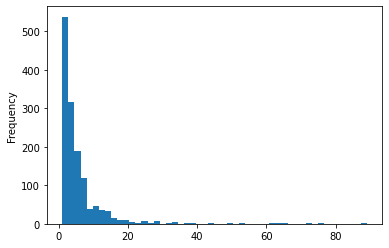

In [0]:
t6['frequency_btyd'].plot(kind='hist', bins=50)
print(t6['frequency_btyd'].describe())
print(sum(t6['frequency_btyd'] == 1)/float(len(t6)))

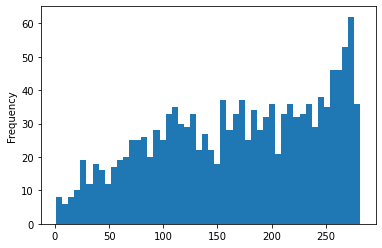

In [0]:
t6['recency'].plot(kind='hist', bins=50)


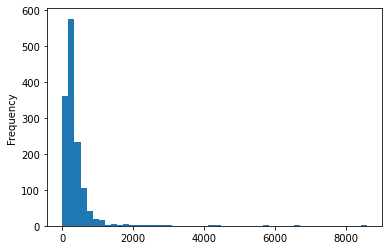

In [0]:
t6['monetary_btyd']= t6['monetary_btyd'].apply(np.int)
t6['monetary_btyd'].plot(kind='hist', bins=50)

## Probabilistic Model

In [0]:
from datetime import datetime
from lifetimes import BetaGeoFitter, ParetoNBDFitter, GammaGammaFitter
import math
import numpy as np
import os
import pandas as pd
import tensorflow as tf

PENALIZER_COEF = 0.01
DISCOUNT_RATE = 0.01

In [0]:
summary = t6[['customer_id', 'frequency_btyd', 'recency', 'T', 'monetary_btyd']]
summary.columns = ['customer_id', 'frequency', 'recency', 'T', 'monetary_value']
summary = summary.set_index('customer_id')

actual_df = t6[['customer_id', 'frequency_btyd', 'monetary_dnn', 'target_monetary']]
actual_df.columns = ['customer_id', 'train_frequency', 'train_monetary', 'act_target_monetary']

In [0]:
def bgnbd_model(summary):
    bgf = BetaGeoFitter(penalizer_coef=PENALIZER_COEF)
    bgf.fit(summary['frequency'], summary['recency'], summary['T'])
    return bgf


def paretonbd_model(summary):
    paretof = ParetoNBDFitter(penalizer_coef=PENALIZER_COEF)
    paretof.fit(summary['frequency'], summary['recency'], summary['T'])
    return paretof

In [0]:
def predict_value(summary, actual_df, fitter, ggf, time_days, time_months):
    ltv = pd.DataFrame(data=np.zeros([actual_df.shape[0], 6]),
                       columns=['customer_id',
                              'actual_total',
                              'predicted_num_purchases',
                              'predicted_value',
                              'predicted_total',
                              'error'], dtype=np.float32)

    predicted_num_purchases = fitter.predict(time_days,
                                           summary['frequency'],
                                           summary['recency'],
                                           summary['T'])

    predicted_value = ggf.customer_lifetime_value(fitter,
                                                summary['frequency'],
                                                summary['recency'],
                                                summary['T'],
                                                summary['monetary_value'],
                                                time=time_months,
                                                discount_rate=DISCOUNT_RATE)

    ltv['customer_id'] = actual_df['customer_id']
    ltv['actual_total'] = actual_df['act_target_monetary']
    ltv['predicted_num_purchases'] = predicted_num_purchases.values
    ltv['predicted_value'] = predicted_value.values
    ltv['predicted_total'] = actual_df['train_monetary'] + ltv['predicted_value']
    ltv['error'] = ltv['actual_total'] - ltv['predicted_total']

    mse = pd.Series.sum(ltv['error'] * ltv['error']) / ltv.shape[0]
    rmse = math.sqrt(mse)

    return ltv, rmse

In [0]:
time_days = (predict_date - threshold_date).days
time_months = int(math.ceil(time_days / 30.0))

In [0]:
ggf = GammaGammaFitter(penalizer_coef=0)
ggf.fit(summary['frequency'], summary['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 1389 subjects, p: 1.24, q: 3.73, v: 790.49>

In [0]:
## bgnbd_model
bgnbd_ltv, bgnbd_rmse = predict_value(summary,
                                    actual_df,
                                    bgnbd_model(summary),
                                    ggf,
                                    time_days,
                                    time_months)

## paretonbd_model
paretonbd_ltv, paretonbd_rmse = predict_value(summary,
                                            actual_df,
                                            paretonbd_model(summary),
                                            ggf,
                                            time_days,
                                            time_months)

/usr/local/lib/python3.6/dist-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


**Final ltv and RMSE for bgnd and pareto model**

In [0]:
b1 = t3[t3['order_date']<threshold_date]
b1 = b1.groupby('customer_id').agg({'order_value':'mean','order_date':'nunique'}).reset_index()
b1.columns = ['customer_id','avg_basket_value','cnt_orders']

b2 = t3.groupby('customer_id').agg({'order_value':'mean'}).reset_index()
b2.columns = ['customer_id','target_monetary']

feature_days = (threshold_date - t3['order_date'].min()).days
target_days = (predict_date - threshold_date).days

b3 = pd.merge(b1,b2,on='customer_id',how='inner')
b3['predicted_monetary'] = b3['avg_basket_value']*(b3['cnt_orders']*(1+target_days/feature_days))
b3['target_monetary'] = b3['target_monetary'].round(2)
b3 = b3[['customer_id','predicted_monetary','target_monetary']]

benchmark_rmse = round(np.sqrt(np.power(b3['predicted_monetary']-b3['target_monetary'],2).sum()/b3.shape[0]),2)

In [0]:
benchmark_rmse, bgnbd_rmse, paretonbd_rmse

(11625.43, 6549.1501609587485, 6436.446051353354)

**Expected future purchases by frequency and recency of customer**

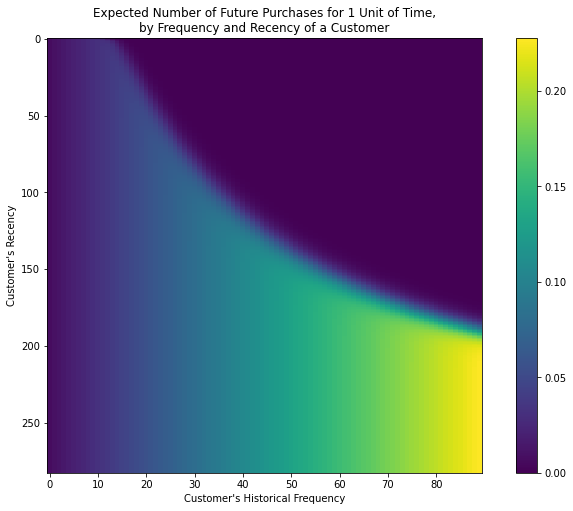

In [0]:
from lifetimes.plotting import plot_frequency_recency_matrix, plot_probability_alive_matrix
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(paretonbd_model(summary))

**Clustering on Recency, Frequency and Monetary values to form segments**

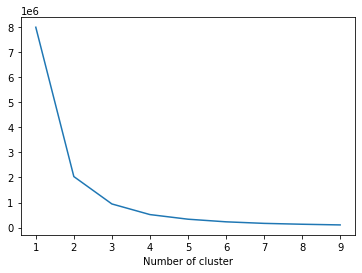

In [0]:
from sklearn.cluster import KMeans


MYSEED = 199
sse={}
t6_recency = t6[['recency']]
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, max_iter=1000).fit(t6_recency)
    t6_recency["clusters"] = kmeans.labels_
    sse[k] = kmeans.inertia_ 
plt.figure()
plt.plot(list(sse.keys()), list(sse.values()))
plt.xlabel("Number of cluster")
plt.show()





**Recency clusters**

In [0]:
kmeans = KMeans(n_clusters=4,random_state=MYSEED)
kmeans.fit(t6[['recency']])
t6['RecencyCluster'] = kmeans.predict(t6[['recency']])

#function for ordering cluster numbers
def order_cluster(cluster_field_name, target_field_name,df,ascending):
    new_cluster_field_name = 'new_' + cluster_field_name
    df_new = df.groupby(cluster_field_name)[target_field_name].mean().reset_index()
    df_new = df_new.sort_values(by=target_field_name,ascending=ascending).reset_index(drop=True)
    df_new['index'] = df_new.index
    df_final = pd.merge(df,df_new[[cluster_field_name,'index']], on=cluster_field_name)
    df_final = df_final.drop([cluster_field_name],axis=1)
    df_final = df_final.rename(columns={"index":cluster_field_name})
    return df_final

t6_cust = order_cluster('RecencyCluster', 'recency',t6,False)

t6_cust.groupby('RecencyCluster')['recency'].describe()


,count,mean,std,min,25%,50%,75%,max
RecencyCluster,,,,,,,,
0,459.0,253.017429,18.095444,219.0,238.0,255.0,269.0,282.0
1,376.0,184.250000,19.795791,150.0,167.0,183.0,202.0,218.0
2,328.0,115.579268,18.415020,83.0,101.0,116.0,130.0,149.0
3,226.0,49.610619,22.134913,1.0,32.5,52.0,70.0,82.0


**Frequency clusters**

In [0]:
kmeans = KMeans(n_clusters=4,random_state=MYSEED)
kmeans.fit(t6[['frequency_btyd']])
t6['FrequencyCluster'] = kmeans.predict(t6[['frequency_btyd']])

#order the frequency cluster
t6_cust = order_cluster('FrequencyCluster', 'frequency_btyd',t6,True)

#see details of each cluster
t6_cust.groupby('FrequencyCluster')['frequency_btyd'].describe()

,count,mean,std,min,25%,50%,75%,max
FrequencyCluster,,,,,,,,
0,1044.0,2.812261,1.586497,1.0,1.00,2.0,4.0,6.0
1,295.0,10.250847,3.045816,7.0,8.00,9.0,13.0,18.0
2,42.0,25.857143,6.237461,19.0,20.25,24.0,29.0,44.0
3,8.0,66.500000,12.581165,50.0,59.75,65.0,73.0,89.0


**Monetary Cluster**

In [0]:
#apply clustering
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=4,random_state=MYSEED)
kmeans.fit(t6[['target_monetary']])
t6['RevenueCluster'] = kmeans.predict(t6[['target_monetary']])


#order the cluster numbers
t6_cust = order_cluster('RevenueCluster', 'target_monetary',t6,True)

#show details of the dataframe
t6_cust.groupby('RevenueCluster')['target_monetary'].describe()

,count,mean,std,min,25%,50%,75%,max
RevenueCluster,,,,,,,,
0,1355.0,3004.059166,3037.454144,36.56,1140.5350,2030.330,3651.4200,21086.30
1,27.0,40980.163333,13284.700404,25748.35,29508.6500,33820.090,52287.2800,65892.08
2,5.0,129039.466000,36656.099983,88125.38,113384.1400,123725.450,132480.1900,187482.17
3,2.0,267963.755000,16299.186073,256438.49,262201.1225,267963.755,273726.3875,279489.02


**Overall score based on RFM clusters**

In [0]:
t6_cust['OverallScore'] = t6_cust['RecencyCluster'] + t6_cust['FrequencyCluster'] + t6_cust['RevenueCluster']
t6_cust.groupby('OverallScore')['recency','frequency_btyd','target_monetary'].mean()

,recency,frequency_btyd,target_monetary
OverallScore,,,
0,49.709821,1.674107,1526.519241
1,182.867508,3.321767,2608.764385
2,116.100313,2.504702,1986.714796
3,232.633745,5.259259,3216.717984
4,215.850000,19.650000,8756.751500
5,256.089686,11.269058,7403.718206
6,263.500000,21.428571,54173.265000
7,269.000000,52.714286,89300.385714
8,275.500000,52.500000,194459.340000


Now we have 9 overall clusters, clearly 
0,1,2,3 Low Value
4 and 5 Mid Value
6,7,8 High Value 

**Segments based on overall scores**

In [0]:

t6_cust['Segment'] = 'Low-Value'
t6_cust.loc[t6_cust['OverallScore']>3,'Segment'] = 'Mid-Value' 
t6_cust.loc[t6_cust['OverallScore']>6,'Segment'] = 'High-Value' 

**Visualizing Segments**

In [0]:
import chart_studio.plotly as py
import plotly.offline as pyoff
import plotly.graph_objs as go
t6_graph  = t6_cust.query("target_monetary < 50000 and frequency_btyd < 2000")

plot_data = [
    go.Scatter(
        x=t6_graph.query("Segment == 'Low-Value'")['frequency_btyd'],
        y=t6_graph.query("Segment == 'Low-Value'")['target_monetary'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=t6_graph.query("Segment == 'Mid-Value'")['frequency_btyd'],
        y=t6_graph.query("Segment == 'Mid-Value'")['target_monetary'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=t6_graph.query("Segment == 'High-Value'")['frequency_btyd'],
        y=t6_graph.query("Segment == 'High-Value'")['monetary_btyd'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Frequency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

#Revenue Recency

t6_graph = t6_cust.query("target_monetary < 50000 and frequency_btyd < 2000")

plot_data = [
    go.Scatter(
        x=t6_graph.query("Segment == 'Low-Value'")['recency'],
        y=t6_graph.query("Segment == 'Low-Value'")['target_monetary'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=t6_graph.query("Segment == 'Mid-Value'")['recency'],
        y=t6_graph.query("Segment == 'Mid-Value'")['target_monetary'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=t6_graph.query("Segment == 'High-Value'")['recency'],
        y=t6_graph.query("Segment == 'High-Value'")['target_monetary'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Revenue"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)

# Revenue vs Frequency
t6_graph = t6_cust.query("target_monetary < 50000 and frequency_btyd < 2000")

plot_data = [
    go.Scatter(
        x=t6_graph.query("Segment == 'Low-Value'")['recency'],
        y=t6_graph.query("Segment == 'Low-Value'")['frequency_btyd'],
        mode='markers',
        name='Low',
        marker= dict(size= 7,
            line= dict(width=1),
            color= 'blue',
            opacity= 0.8
           )
    ),
        go.Scatter(
        x=t6_graph.query("Segment == 'Mid-Value'")['recency'],
        y=t6_graph.query("Segment == 'Mid-Value'")['frequency_btyd'],
        mode='markers',
        name='Mid',
        marker= dict(size= 9,
            line= dict(width=1),
            color= 'green',
            opacity= 0.5
           )
    ),
        go.Scatter(
        x=t6_graph.query("Segment == 'High-Value'")['recency'],
        y=t6_graph.query("Segment == 'High-Value'")['frequency_btyd'],
        mode='markers',
        name='High',
        marker= dict(size= 11,
            line= dict(width=1),
            color= 'red',
            opacity= 0.9
           )
    ),
]

plot_layout = go.Layout(
        yaxis= {'title': "Frequency"},
        xaxis= {'title': "Recency"},
        title='Segments'
    )
fig = go.Figure(data=plot_data, layout=plot_layout)
pyoff.iplot(fig)